## In this ipython notebook we will consider our method of constructing nonlinear interactions

In [1]:
import Roots
import Potapov
import Examples
import Time_Sims
import functions
import tests

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
Ex = Examples.Example3(r1 = 0.99, r3 = 0.99)
Ex.run_Potapov()

E = Ex.E
roots = Ex.roots
M1 = Ex.M1
delays = Ex.delays
modes = functions.spatial_modes(roots,M1,E)

In [26]:
roots

[(-0.034316016800108838-32.541748364590951j),
 (-0.032406470672794466-20.178502359262513j),
 (-0.034831563299396441-10.9014910482432j),
 (-0.034831563299396032+10.9014910482432j),
 (-0.032212614753084144+5.9767582314101303e-17j),
 (-0.032406470672794424+20.178502359262513j),
 (-0.034316016800108755+32.541748364590958j),
 (-0.03344113933259261+53.73037177716278j),
 (-0.03300911480921513+40.60519219295127j),
 (-0.033441139332592636-53.73037177716278j),
 (-0.03300911480921292-40.60519219295128j)]

In [5]:
root_z = lambda z: 1j*z  ## a fake root we will vary

In [6]:
roots_to_use = lambda z: [root_z(z),roots[-1],roots[-2]]

In [7]:
modes_to_use = [modes[-1],modes[-1], modes[4]]

In [8]:
delay_index = 0

In [9]:
plus_or_minus_arr =  [-1,-1,-1]

In [11]:
x = np.linspace(-300,260,1000)

In [38]:
f = lambda z: functions.make_nonlinear_interaction(roots_to_use(z),modes_to_use,Ex.delays,0,0,0.1,plus_or_minus_arr)

In [40]:
### by default, indices_of_refraction=[1,1,1]

We will vary the fake root we introduced to obtain the phase-mismatch diagram. That is, the phase mismatch $\delta k$ is going to be some linear function of $z$.

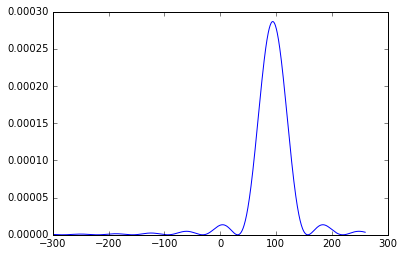

In [41]:
plt.plot(x, [abs(f(z))**2 for z in x])

What happens when we change the indices of refraction for the different modes? The phase-mismatch will shift depending on where the new $\delta k = 0$ occurs. The width of the peak may also change if the indices of refraction are large.

In [45]:
indices_of_refraction=[3.,1.1,2.]

In [46]:
f = lambda z: functions.make_nonlinear_interaction(roots_to_use(z),
                modes_to_use,Ex.delays,0,0,0.1,plus_or_minus_arr,indices_of_refraction=indices_of_refraction)

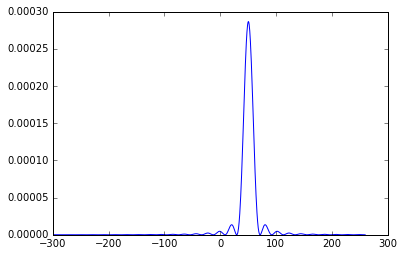

In [47]:
plt.plot(x, [abs(f(z))**2 for z in x])